In [1]:
import RunFullMap
import numpy as np
import scipy.linalg
import keras.backend as K
import tensorflow as tf
import sklearn.manifold
import sklearn.metrics

import Diffusion as df
import os.path
from autoencoder import *

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

from keras.utils import np_utils
from keras.layers import Dense, Input
from keras.models import Model
from keras import regularizers

from pcn import PolynomialPointCurve
import LaplacianEigenmaps




Using TensorFlow backend.


In [2]:
n = 3000
t = 2.01*np.pi*np.random.uniform(0,1,n)
x = np.cos(t)
y = np.sin(2*t)
z = np.sin(3*t)
orig_data = np.vstack([x,y,z])
orig_data = np.transpose(orig_data)

TRAIN_SAMPLES = 2000

train_data = orig_data[:TRAIN_SAMPLES]
eval_data = orig_data[TRAIN_SAMPLES:]

pred_net = RunFullMap.DiffusionNet(train_data, 2, embedding='laplacian')

Gpu available:  True


W0410 13:53:46.440510 139624069392192 deprecation_wrapper.py:119] From /home/stephen/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0410 13:53:46.441126 139624069392192 deprecation_wrapper.py:119] From /home/stephen/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0410 13:53:46.442423 139624069392192 deprecation_wrapper.py:119] From /home/stephen/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0410 13:53:46.452252 139624069392192 deprecation_wrapper.py:119] From /home/stephen/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:1521: The name tf.log is deprecated. Please use tf.math.log instead.

W0410 13:53:46.4

Using laplacian embedding
Done embedding
Done encoder
Done decoder


W0410 13:54:08.397405 139624069392192 deprecation_wrapper.py:119] From /home/stephen/Desktop/diffusion_net/RunFullMap.py:144: The name tf.train.AdamOptimizer is deprecated. Please use tf.compat.v1.train.AdamOptimizer instead.



In [3]:
res = pred_net.predict(eval_data)

(1000, 3)
(1000, 3)


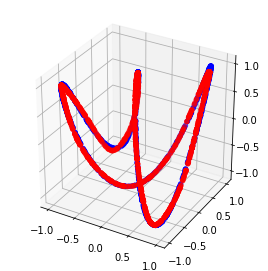

In [4]:
fig = plt.figure(figsize=(10,5))
#a1 = fig.add_subplot(121)
#a1.scatter(z_test[:,0], z_test[:,1],c=t_test, cmap='gist_ncar')
#a1.set_aspect('equal')
#a1.set_title('eta=' +str(eta))

a2 = fig.add_subplot(122,projection='3d')
a2.scatter(eval_data[:,0], eval_data[:,1], eval_data[:,2], color='blue')
print(eval_data.shape)
print(res.shape)
a2.scatter(res[:,0], res[:,1], res[:,2], color='red', zorder=10)
#a2.set_title('eta=' +str(eta))
a2.set_aspect('equal')
plt.show()